# Estimating a dynamic Augmented Markov Model from Synthetic Data
In this tutorial, we will estimate a dynamic Augmented Markov model for synthetic experimental and simulation data generated from the double-well potential.
First, let's generate the data using the script `scripts/toy/generate-double-well-data.py`:

In [1]:
%run ./scripts/toy/generate-double-well-data.py

In [2]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from deeptime.markov.msm import MaximumLikelihoodMSM
from dynamics_utils.file_handling.load_files import HDFLoader
from dynamics_utils.msm import calculate_acf_from_spectral_components, calculate_stationary_observable

from dynAMMo.tools.definitions import ROOTDIR, quantitative_1
from dynAMMo.base.experiments import DynamicExperiment, StaticExperiment
from dynAMMo.model.estimator import  DynamicAugmentedMarkovModelEstimator
from dynAMMo.base.msm import DynamicAugmentedMarkovModel
from dynAMMo.manifold.stiefel import StiefelUpdate
from dynAMMo.tools.plot import PlotDynAMMo
from dynAMMo.tools.file_handling.save_data import save_spectral_components
import training.utils

import matplotlib as mpl
mpl.rcParams["axes.prop_cycle"] = quantitative_1

Now we load the synthetic experimental and simulation trajectories as well as the config file.

In [3]:
data_dir = ROOTDIR / 'data/toy/double-well/'
experimental_dtraj = HDFLoader(data_dir / 'experimental-data.h5').read('dtraj')
simulation_dtraj = HDFLoader(data_dir / 'simulation-data.h5').read('dtraj')
config = training.utils.load_config(ROOTDIR / 'config/double-well-tutorial.json')

Looking at the histogram of the trajectory data, we can clearly see that there is a discrepancy between the experiments and simulations.

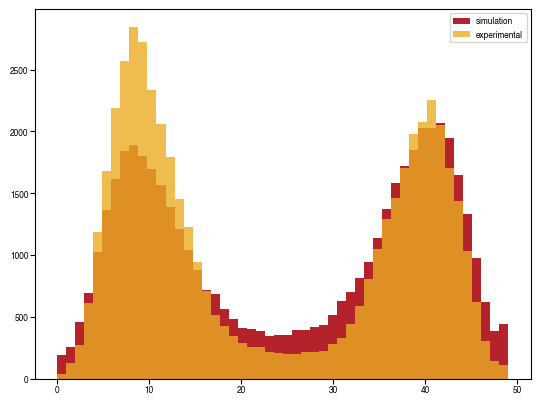

In [4]:
plt.hist(simulation_dtraj, bins=50, alpha=1.0, label='simulation')
plt.hist(experimental_dtraj, bins=50, alpha=0.8, label='experimental')
plt.legend()
plt.show()

Typically, we never have access to the experimental trajectory. Instead, we  obtain so-called observables.
Observables are essentially physical quantities that can be measured in experiments or calculated from simulations, serving as a bridge between theoretical models and practical experimentation.
Stationary observables refer to those properties of a system that remain constant over time, reflecting the system's equilibrium characteristics. Examples include properties like melting temperature, the content of secondary structures in biomolecules, or molecular weight. Formally, for a function $a: X \rightarrow \mathbb{C}^n \text{ or } \mathbb{R}^n$, where $X$ encompasses all possible configurations $\mathbf{x}$ within some state space $\Omega$, the stationary observable $o^{\text{stat}}_a$ is defined as:
$$
    o^{\text{stat}}_a = \int_\Omega a(\mathbf{x}) \pi(\mathbf{x}) \, \text{d} \mathbf{x}.
$$

The integral calculates the weighted average of $f$ over all configurations, with $\pi(\mathbf{x})$ representing the probability density function of the system's states. Essentially, this tells us how to compute averages that characterize the equilibrium state of the system.

On the other hand, dynamic observables are concerned with how the system evolves over time, making them inherently time dependent. These are particularly relevant for understanding the kinetics of a system, such as how quickly a molecule transitions between different states or how long it remains in a specific state. They typically come in the form of an autocorrelation function, which assesses how a property of the system at one time point is correlated with its value at another time point, separated by a time lag $\tau$. The mathematical expression for a dynamic observable involving the functions $f$ is given by:

$$
    o^{\text{dyn}}_{aa}(k\tau) = \int_\Omega \int_\Omega a(\mathbf{x}_t) a(\mathbf{x}_{t+k\tau}) p_\tau (\mathbf{x}_{t+k\tau} | \mathbf{x}_t) \boldsymbol{\pi}(\mathbf{x}) \, \text{d} \mathbf{\mathbf{x}}_t \, \text{d} \mathbf{\mathbf{x}}_{t+k\tau},
$$

where $p_\tau (\mathbf{x}_{t+k\tau} | \mathbf{x}_t)$ represents the transition density, capturing the probability of moving from one state at time $t$ to another at time $t+k\tau$. The equation integrates over all pairs of states to compute the weighted correlation of $a$ across time, offering insights into the system's dynamics.

Dynamic observables are invaluable for studying phenomena such as relaxation processes or the spectral properties of systems, which relate to how the system returns to equilibrium or how different energy states exchange populations over time. Techniques to measure these observables include various types of relaxation experiments and single-molecule fluorescence techniques, which, while not measuring time correlations directly, provide critical information about the dynamics of molecular systems.

By comparing experimental data on dynamic observables with predictions from computational models, we can use dynAMMo to complement the inherently limited observability of experiments with the bias found in simulation data to estimate a model of molecular kinetics that allows for a mechanistic understanding (from simulations) but with the timescales of the ''true'' ensemble.
 In order to calculate a time correlation function from the experimental data, let's first estimate a Markov model. In addition, we also need some observable function, which, in our case, will be the second right eigenvector. That is, the slowest process that transports the probability density from one part of state space to another:

In [5]:
lag = config['lag']
# k will be an integer multiple of our lag time tau
k = torch.arange(0, 70, 1)

# Estimate an MSM from the experimental trajectory and saving it accordingly.
msm_exp = MaximumLikelihoodMSM(reversible=True).fit(experimental_dtraj.numpy(), lagtime=lag).fetch_model()
save_spectral_components(data_dir / 'experimental-msm.h5', msm_exp)

# Do the same for the simulation trajectory
msm_calc = MaximumLikelihoodMSM(reversible=True).fit(simulation_dtraj.numpy(), lagtime=lag).fetch_model()
save_spectral_components(data_dir / 'simulation-msm.h5', msm_calc)

# Define our observable-by-state vector, the discrete equivalent of the observable function a
a = torch.from_numpy(msm_exp.eigenvectors_right()[:, 1])
observable_function = calculate_acf_from_spectral_components

Now that we have the two MSMs, let's "measure" the experimental autocorrelation function and compare it with the prediction from the MSM derived from simulations.
We can conveniently store the dynamic and stationary observables in the `DynamicExperiment` and `StaticExperiment` class, respectively.

In [13]:
experiments = []
dynamic_experiment = DynamicExperiment(
    indep_var=k,
    observables_by_state=a,  # microscopic observable
    observable_function=observable_function,
    name='second right eigenvector'
)
dynamic_experiment.observables_msm = dynamic_experiment(
    msm_calc.eigenvectors_left().T, 
    msm_calc.eigenvalues()[1:],
    lagtime=lag
)
dynamic_experiment.observables_pred = dynamic_experiment.observables_msm

dynamic_experiment.observables_exp = observable_function(
        k = k,
        a = a,
        leigvecs = msm_exp.eigenvectors_left().T,
        eigvals = msm_exp.eigenvalues()[1:],
        lag = lag,
    )

static_experiment = StaticExperiment(
    observables_by_state=a,  # microscopic observable
    name='second right eigenvector'
)
static_experiment.observables_msm = static_experiment(
    torch.from_numpy(msm_calc.stationary_distribution)
)
static_experiment.observables_pred = static_experiment.observables_msm


static_experiment.observables_exp = calculate_stationary_observable(
    a[:, None],
    msm_exp.stationary_distribution
)

experiments.append(dynamic_experiment)
experiments.append(static_experiment)

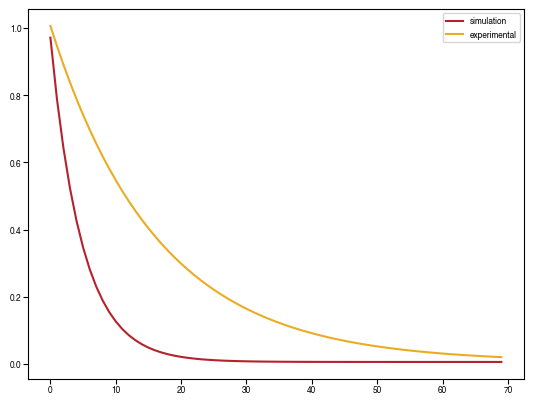

In [7]:
plt.plot(k, dynamic_experiment.observables_msm.T, label='simulation')
plt.plot(k, dynamic_experiment.observables_exp.T, label='experimental')
plt.legend()
plt.show()

Indeed, there is an obvious discrepancy between the predicted function and the experimentally "observed" one. Our goal will be to match the predictions with the experimental evidence.

At the heart of MSMs lies the transition matrix $\mathbf{T}$, a square matrix where each element $\mathbf{T}_{ij}$ represents the probability of moving from state $i$ to state $j$ after a certain time lag. This matrix isn't just a matrix containing transition probabilities; under equilibrium conditions, it adheres to the principles that ensure the model reflects physical reality. These principles include reversibility (the system can move back and forth between states in a way that respects the balance of transitions), ergodicity (every state can eventually be reached from any other state), and row stochasticity (the probabilities in each row add up to 1).

MSMs are powerful because they can predict both stationary and dynamic observables, bridging the gap between computational predictions and experimental findings. 
A closer look at the mathematics of the transfer operator formalism, and its approximation, the Markov state model, reveals a direct link between the eigenvalues of the transition matrix and the system's relaxation dynamics. Specifically, the decay rates in time correlation functions are directly tied to the eigenvalues, which denote different timescales of the system's dynamics. The amplitudes of these decay processes, denoted as $c_i$, can be calculated using the spectral decomposition of the transfer operator. This decomposition allows for a concise representation of dynamic observables within the MSM framework:

$$
    c_i = (\mathbf{a} \cdot \boldsymbol{\phi}_i)^2,
$$

where $\boldsymbol{\phi}_i$ is the $i$th left eigenvector. This setup provides a formula for dynamic observables in MSMs as a sum of exponential decays modulated by these amplitudes:

$$
    o^{\text{dyn, MSM}}_{aa} (k\tau) = c_1 + \sum_{i=2}^n c_i \exp \left( -\frac{k\tau}{t^{\text{ex}}_i}\right),
$$

with $c_1$ representing the amplitude of the stationary distribution $\pi$ and

$$
\lambda_i (k\tau) = \exp \left(- \frac{k\tau}{t^\text{ex}_i} \right).
$$

Here, $\lambda_i$ is the eigenvalue corresponding to the $i$th eigenvector. This framework offers us a way to compare and validate computational models against experimental data.

## Setting up the dynamic Augmented Markov Model
Now we are ready to estimate a dynAMMo:

In [8]:
# Initialize dynAMMo using the MSM estimated from the simulation data. Remember that in reality, we don't have access to the experimental one!
dynammo = DynamicAugmentedMarkovModel(
    [msm_calc.transition_matrix],
    [msm_calc.stationary_distribution],
    [msm_calc.count_model],
    observables_by_state=[a],
)

# Since optimizing the stationary distribution and eigenvalues requires changing the eigenvectors with them, we need to use a special gradient update scheme. That is because the eigenvector matrix of the MSM is orthonormal. In order to stay on the manifold of orthonormal functions (the Stiefel manifold), we can use the following:
stiefel_eigfuncs = StiefelUpdate(config['lr_stiefel'])

# Initialize dynAMMo estimator
model = DynamicAugmentedMarkovModelEstimator(
    msm=dynammo,
    experiments=experiments,
    eigfuncs=stiefel_eigfuncs,
    config=config,
)

# Save the predictions from the MSM for comparison later
model.dynamic_observables_msm = dynamic_experiment.observables_msm


# Set up optimizers
optimizer = training.utils.set_up_optimizer(config, model)

# Define results file
results_filename = ROOTDIR / config["out"] / "results.h5"
results_filename.parent.mkdir(parents=True, exist_ok=True)

# Initialize the plotting utility
plots = PlotDynAMMo()

Now we can start training the model:

In [9]:
training.utils.training_loop(
    model,
    optimizer,
    plots,
    config,
    results_filename,
)

~~~ *** ~~~ Static AMM converged ~~~ *** ~~~
10802.544955720163
4043.8162225367087
73.55695747273124
73.42459615106287
74.77560335363079
73.11072455779718
Converged after 3000 epochs


Once training is finished, we can have a look at the results:

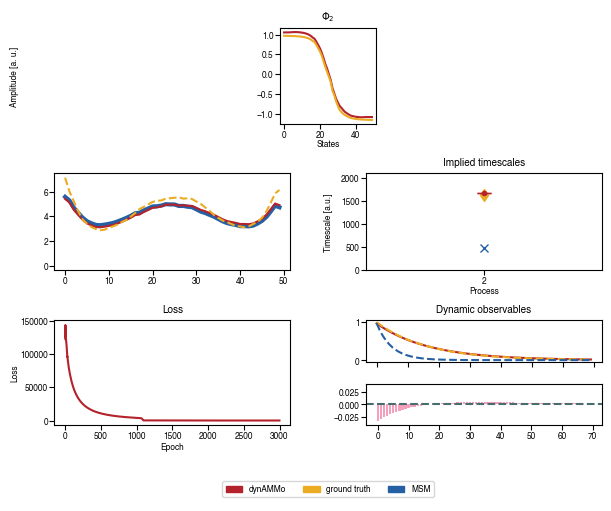

In [10]:
plots = PlotDynAMMo(dark_theme=False, results=results_filename, plot_msm=True)
plots.make_toy_figure_supplement()
plt.show()

We can see that we did indeed match the observables perfectly and, as a consequence, also the timescale of exchange matches the ground truth.